#Import libraies and packages

In [ ]:
pip install ray torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60.5 MB 1.2 MB/s 
     |████████████████████████████████| 4.1 MB 66.3 MB/s 
     |████████████████████████████████| 8.8 MB 59.6 MB/s 
     |████████████████████████████████| 468 kB 75.8 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.50.0
    Uninstalling grpcio-1.50.0:
      Successfully uninstalled grpcio-1.50.0


In [ ]:
pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pandas as pd
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.suggest import ConcurrencyLimiter

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: The module `ray.tune.suggest` has been moved to `ray.tune.search` and the old location will be deprecated soon. Please adjust your imports to point to the new location. Example: Do a global search and replace `ray.tune.suggest` with `ray.tune.search`.
  if sys.path[0] == '':


In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings("ignore")

# 2. Seconda try

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, dim):
        super(ConvNet, self).__init__()
        # In this example, we don't change the model architecture
        # due to simplicity.
        self.dim=dim
        self.conv1 = nn.Conv1d(30, 1, 3)
        self.fc = nn.Linear(28, 14)
        self.fc2 = nn.Linear(14, 7)       
        self.fc3 = nn.Linear(7, 1)

        self.item_embedding = torch.nn.Embedding(num_embeddings=39, embedding_dim=30)
    def forward(self, x):
        x = torch.tensor(x).to(torch.int)
        x = self.item_embedding(x)
        x = x.squeeze(1)
        x = F.relu(self.conv1(x))
        x = self.fc(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = F.sigmoid(x).squeeze(1)
        return x

In [ ]:
from ray import air, tune
import random
from torch.utils.data import DataLoader
import tensorflow as tf


In [ ]:
path ='/content/drive/MyDrive/UPM/Internship/Clinical_data_and_RNA_30_Features_PFS.csv'
data_frame = pd.read_csv(path)

X = data_frame[['AC005307.1', 'ATP5G2P1', 'DLGAP4', 'EIF4A1P9', 'FAM172BP', 'FAM224A', 'GJA9', 'GPR155', 'GYPE', 'IL25', 'KLHL5', 'LANCL1-AS1', 'LEMD1', 'PCMT1', 'RP11-120J4.1', 'RP11-20G6.3', 'RP11-349G13.2', 'RP11-374M1.2', 'RP11-536C10.21', 'RP11-95G17.2', 'RP11-96O20.4', 'RP5-827C21.1', 'RPS12P26', 'SDR42E1', 'SNORD113-5', 'TARBP2', 'TRAV41', 'TRIM43B', 'VN2R17P', 'XPC']] #Seleccionamos todas las columnas quitando la columna Unnamed (id de la fila ) y la columna Target.
Y=[]
for i in range (len(data_frame)):
  if data_frame.PFS[i]<3: # If PFS is lower than 3 months, I will consider it as NonResponder (NR)
      Y.append(0)
  else:
      Y.append(1)# If PFS is over 3 months, I will consider it as Responder (R)

for g in range(len(X)):
  b=[]
  if Y[g] == 0:
    for i in X.iloc[g].to_numpy():
      X.iloc[g]=0
  else:
    for i in X.iloc[g].to_numpy():
      X.iloc[g]=5
print(Y)
X

[1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]


,AC005307.1,ATP5G2P1,DLGAP4,EIF4A1P9,FAM172BP,FAM224A,GJA9,GPR155,GYPE,IL25,...,RP11-96O20.4,RP5-827C21.1,RPS12P26,SDR42E1,SNORD113-5,TARBP2,TRAV41,TRIM43B,VN2R17P,XPC
0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
1,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
2,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
178,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def train_mnist(config):
    # Data Setup
    list_data_0=[]
    list_data_1=[]
    path ='/content/drive/MyDrive/UPM/Internship/Clinical_data_and_RNA_30_Features_PFS.csv'
    data_frame = pd.read_csv(path)
    
    X = data_frame[['AC005307.1', 'ATP5G2P1', 'DLGAP4', 'EIF4A1P9', 'FAM172BP', 'FAM224A', 'GJA9', 'GPR155', 'GYPE', 'IL25', 'KLHL5', 'LANCL1-AS1', 'LEMD1', 'PCMT1', 'RP11-120J4.1', 'RP11-20G6.3', 'RP11-349G13.2', 'RP11-374M1.2', 'RP11-536C10.21', 'RP11-95G17.2', 'RP11-96O20.4', 'RP5-827C21.1', 'RPS12P26', 'SDR42E1', 'SNORD113-5', 'TARBP2', 'TRAV41', 'TRIM43B', 'VN2R17P', 'XPC']] #Seleccionamos todas las columnas quitando la columna Unnamed (id de la fila ) y la columna Target.
    Y=[]
    for i in range (len(data_frame)):
      if data_frame.PFS[i]<3: # If PFS is lower than 3 months, I will consider it as NonResponder (NR)
          Y.append(0)
      else:
          Y.append(1)# If PFS is over 3 months, I will consider it as Responder (R)

    # for g in range(len(X)):
    #   b=[]
    #   if Y[g] == 0:
    #     for i in X.iloc[g].to_numpy():
    #       X.iloc[g]=0
    #   else:
    #     for i in X.iloc[g].to_numpy():
    #       X.iloc[g]=10

    for g in range(len(X)):
      b=[]
      for i in X.iloc[g].to_numpy():
        a=[]
        a.append(i)
        b.append(a)
      x = torch.tensor([b], dtype=torch.float).reshape([-1])
      y = torch.tensor([Y[g]], dtype=torch.float).reshape([-1, 1])
      if y == 0:
        list_data_0.append([x, y])
      else:
        list_data_1.append([x, y])
    print(list_data_0[0])

    random.shuffle(list_data_0)
    random.shuffle(list_data_1)

    train_dataset = list_data_0[0:72]
    test_dataset = list_data_0[72:86]
    train_dataset = train_dataset + list_data_1[0:82]
    test_dataset = test_dataset + list_data_1[82:97]
    random.shuffle(train_dataset)
    random.shuffle(test_dataset)
    print(f'Number of training patients: {len(train_dataset)}')
    print(f'Number of test patients: {len(test_dataset)}')
    cont = 0
    cont1=0
    for i in train_dataset:
        if i[1] == 0:
            cont+=1
    for i in test_dataset:
        if i[1] == 0:
            cont1+=1
    print("Negative cases from train: " + str(cont) + " of " + str(len(train_dataset)) + " = " + str(cont/len(train_dataset)))
    print("Negative cases from test: " + str(cont1) + " of " + str(len(test_dataset)) + " = " + str(cont1/len(test_dataset)))
    print("It should be 46.9")

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    for step, data in enumerate(train_loader):
        print(f'Step {step + 1}:')
        print('=======')
        print(f'Number of graphs in the current batch: {len(data[0])}')
        # print(data)
        print()

    # Create model
    model = ConvNet(dim = len(data[0]))

    # Compile model with losses and metrics
    optimizer = optim.SGD(
        model.parameters(), lr=config["lr"], momentum=config["momentum"])
    # optimizer=torch.optim.Adam(model.parameters(), lr =config['lr'])

    for i in range(70):
            loss = train(model, optimizer, train_loader)
            acc = test(model, test_loader)

            # Send the current training result back to Tune
            tune.report(mean_accuracy=acc, loss = loss)

            if i % 5 == 0:
                # This saves the model to the trial directory
                torch.save(model.state_dict(), "model.pth")


In [ ]:
def train(model, optimizer, train_loader):
    model.train()
    criterion = nn.BCELoss()
    loss_all = 0
    for i, data in enumerate(train_loader,0):
        inputs, labels = data
        output = model(inputs.squeeze(1))
        loss = criterion(output, labels.squeeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_all += loss.item()

    return loss_all / len(train_loader)


def test(model, loader):
    model.eval()
    correct = 0
    for data in loader:
        inputs, labels = data
        output = model(inputs.squeeze(1))
        for i in range(len(output)):
            if output[i]>0.5:
                output[i]=1
            else:
                output[i]=0
            if output[i]==labels[i]:
                correct=correct+1
    # print("Correct: "+str(correct) +" of "+str(len(loader.dataset)))
    return correct / len(loader.dataset)

In [ ]:
from hyperopt import hp
from ray.tune.search.hyperopt import HyperOptSearch

# space = {
#     "lr": hp.loguniform("lr", 0.001, 0.09),
#     "momentum": hp.uniform("momentum", 0.1, 0.2),
# }

space = {
    "lr": 0.0882,
    "momentum": 0.6103
}
hyperopt_search = HyperOptSearch(space, metric="mean_accuracy", mode="max")

tuner = tune.Tuner(
    train_mnist,
    tune_config=tune.TuneConfig(
        num_samples=5,
        search_alg=hyperopt_search,
    ),
)
results = tuner.fit()


2022-11-04 10:46:23,595	WARNING callback.py:109 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


Trial name,status,loc,lr,momentum,acc,iter,total time (s),loss
train_mnist_ece4673a,TERMINATED,172.28.0.2:23408,0.0882,0.6103,0.740741,70,1.37587,0.00791866
train_mnist_eea99766,TERMINATED,172.28.0.2:23444,0.0882,0.6103,0.666667,70,1.38073,0.196521
train_mnist_eeb75f18,TERMINATED,172.28.0.2:23408,0.0882,0.6103,0.555556,70,1.29223,0.00560608
train_mnist_ef7da6be,TERMINATED,172.28.0.2:23408,0.0882,0.6103,0.555556,70,1.71805,0.095759
train_mnist_f0461be4,TERMINATED,172.28.0.2:23408,0.0882,0.6103,0.814815,70,0.91776,0.00218852


Result for train_mnist_ece4673a:
  date: 2022-11-04_10-46-26
  done: false
  experiment_id: 80d3337191b544539f41d8f6795a7b0c
  hostname: ed66aaf08fcd
  iterations_since_restore: 1
  loss: 0.7028720378875732
  mean_accuracy: 0.48148148148148145
  node_ip: 172.28.0.2
  pid: 23408
  time_since_restore: 0.10760712623596191
  time_this_iter_s: 0.10760712623596191
  time_total_s: 0.10760712623596191
  timestamp: 1667558786
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: ece4673a
  warmup_time: 0.007250547409057617
  
(train_mnist pid=23408) [tensor([21.0554, 21.3003, 34.4118, 26.7616, 21.6293, 21.1237, 29.2922, 30.7290,
(train_mnist pid=23408)         23.0570, 21.0804, 33.7957, 21.3999, 29.7076, 33.5030, 21.4144, 21.3655,
(train_mnist pid=23408)         21.0655, 21.2466, 28.4511, 21.1485, 21.1875, 23.0343, 30.1914, 22.8373,
(train_mnist pid=23408)         21.3274, 30.3542, 22.2215, 21.9744, 21.1286, 31.6356]), tensor([[0.]])]
(train_mnist pid=23408) Number of training patien

(train_mnist pid=23408) /usr/local/lib/python3.7/dist-packages/ray/_private/workers/default_worker.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(train_mnist pid=23408)   from ray._private.ray_logging import configure_log_file, get_worker_log_file_name
(train_mnist pid=23408) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
(train_mnist pid=23408)   warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Result for train_mnist_ece4673a:
  date: 2022-11-04_10-46-27
  done: true
  experiment_id: 80d3337191b544539f41d8f6795a7b0c
  experiment_tag: 1_lr=0.0882,momentum=0.6103
  hostname: ed66aaf08fcd
  iterations_since_restore: 70
  loss: 0.007918663478145996
  mean_accuracy: 0.7407407407407407
  node_ip: 172.28.0.2
  pid: 23408
  time_since_restore: 1.375866413116455
  time_this_iter_s: 0.029330968856811523
  time_total_s: 1.375866413116455
  timestamp: 1667558787
  timesteps_since_restore: 0
  training_iteration: 70
  trial_id: ece4673a
  warmup_time: 0.007250547409057617
  
Result for train_mnist_eeb75f18:
  date: 2022-11-04_10-46-28
  done: false
  experiment_id: 80d3337191b544539f41d8f6795a7b0c
  hostname: ed66aaf08fcd
  iterations_since_restore: 1
  loss: 0.6892489393552145
  mean_accuracy: 0.5555555555555556
  node_ip: 172.28.0.2
  pid: 23408
  time_since_restore: 0.07741403579711914
  time_this_iter_s: 0.07741403579711914
  time_total_s: 0.07741403579711914
  timestamp: 1667558788
 

(train_mnist pid=23444) /usr/local/lib/python3.7/dist-packages/ray/_private/workers/default_worker.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(train_mnist pid=23444)   from ray._private.ray_logging import configure_log_file, get_worker_log_file_name
(train_mnist pid=23444) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
(train_mnist pid=23444)   warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(train_mnist pid=23444) [tensor([21.0554, 21.3003, 34.4118, 26.7616, 21.6293, 21.1237, 29.2922, 30.7290,
(train_mnist pid=23444)         23.0570, 21.0804, 33.7957, 21.3999, 29.7076, 33.5030, 21.4144, 21.3655,
(train_mnist pid=23444)         21.0655, 21.2466, 28.4511, 21.1485, 21.1875, 23.0343, 30.1914, 22.8373,
(train_mnist pid=23444)         21.3274, 30.3542, 22.2215, 21.9744, 21.1286, 31.6356]), tensor([[0.]])]
(train_mnist pid=23444) Number of training patients: 154
(train_mnist pid=23444) Number of test patients: 27
(train_mnist pid=23444) Negative cases from train: 72 of 154 = 0.4675324675324675
(train_mnist pid=23444) Negative cases from test: 13 of 27 = 0.48148148148148145
(train_mnist pid=23444) It should be 46.9
(train_mnist pid=23444) Step 1:
(train_mnist pid=23444) =======
(train_mnist pid=23444) Number of graphs in the current batch: 64
(train_mnist pid=23444) 
(train_mnist pid=23444) Step 2:
(train_mnist pid=23444) =======
(train_mnist pid=23444) Number of graphs in the cu

2022-11-04 10:46:32,219	INFO tune.py:759 -- Total run time: 8.65 seconds (8.35 seconds for the tuning loop).


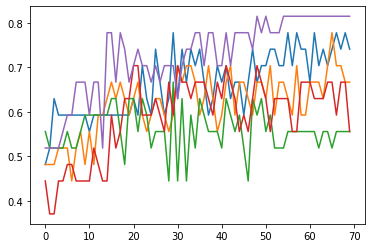

In [ ]:
dfs = {result.log_dir: result.metrics_dataframe for result in results}
[d.mean_accuracy.plot() for d in dfs.values()]

In [ ]:
from hyperopt import hp
from ray.tune.search.hyperopt import HyperOptSearch

# space = {
#     "lr": hp.loguniform("lr", 0.01, 0.09),
#     "momentum": hp.uniform("momentum", 0.1, 0.9),
# }

space = {
    "lr": 0.0583,
    "momentum": 0.1297
}
hyperopt_search = HyperOptSearch(space, metric="mean_accuracy", mode="max")

tuner = tune.Tuner(
    train_mnist,
    tune_config=tune.TuneConfig(
        num_samples=30,
        search_alg=hyperopt_search,
    ),
)
results = tuner.fit()


2022-11-04 09:18:56,620	WARNING callback.py:109 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


Trial name,status,loc,lr,momentum,acc,iter,total time (s),loss
train_mnist_b573ca04,TERMINATED,172.28.0.2:18570,0.0583,0.1297,0.642857,100,1.87178,0.179151
train_mnist_b728488e,TERMINATED,172.28.0.2:18604,0.0583,0.1297,0.535714,100,2.06824,0.176759
train_mnist_b72ceefc,TERMINATED,172.28.0.2:18570,0.0583,0.1297,0.607143,100,1.8189,0.339448
train_mnist_b847d1a8,TERMINATED,172.28.0.2:18570,0.0583,0.1297,0.714286,100,2.04729,0.386605
train_mnist_b960769e,TERMINATED,172.28.0.2:18604,0.0583,0.1297,0.642857,100,1.65009,0.207384
train_mnist_ba55f894,TERMINATED,172.28.0.2:18570,0.0583,0.1297,0.464286,100,1.88174,0.193353
train_mnist_ba9bb870,TERMINATED,172.28.0.2:18604,0.0583,0.1297,0.678571,100,1.88104,0.301888
train_mnist_bb55f7bc,TERMINATED,172.28.0.2:18570,0.0583,0.1297,0.678571,100,1.69622,0.409661
train_mnist_bbbd0c22,TERMINATED,172.28.0.2:18604,0.0583,0.1297,0.678571,100,1.6522,0.466061
train_mnist_bc779394,TERMINATED,172.28.0.2:18570,0.0583,0.1297,0.571429,100,1.68178,0.277422


(train_mnist pid=18570) /usr/local/lib/python3.7/dist-packages/ray/_private/workers/default_worker.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(train_mnist pid=18570)   from ray._private.ray_logging import configure_log_file, get_worker_log_file_name
(train_mnist pid=18570) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
(train_mnist pid=18570)   warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(train_mnist pid=18570) [tensor([21.0554, 21.3003, 34.4118, 26.7616, 21.6293, 21.1237, 29.2922, 30.7290,
(train_mnist pid=18570)         23.0570, 21.0804, 33.7957, 21.3999, 29.7076, 33.5030, 21.4144, 21.3655,
(train_mnist pid=18570)         21.0655, 21.2466, 28.4511, 21.1485, 21.1875, 23.0343, 30.1914, 22.8373,
(train_mnist pid=18570)         21.3274, 30.3542, 22.2215, 21.9744, 21.1286, 31.6356]), tensor([[0.]])]
(train_mnist pid=18570) Number of training patients: 153
(train_mnist pid=18570) Number of test patients: 28
(train_mnist pid=18570) Negative cases from train: 72 of 153 = 0.47058823529411764
(train_mnist pid=18570) Negative cases from test: 13 of 28 = 0.4642857142857143
(train_mnist pid=18570) It should be 46.9
(train_mnist pid=18570) Step 1:
(train_mnist pid=18570) =======
(train_mnist pid=18570) Number of graphs in the current batch: 64
(train_mnist pid=18570) 
(train_mnist pid=18570) Step 2:
(train_mnist pid=18570) =======
(train_mnist pid=18570) Number of graphs in the cu

(train_mnist pid=18604) /usr/local/lib/python3.7/dist-packages/ray/_private/workers/default_worker.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(train_mnist pid=18604)   from ray._private.ray_logging import configure_log_file, get_worker_log_file_name
(train_mnist pid=18604) /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
(train_mnist pid=18604)   warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Result for train_mnist_b72ceefc:
  date: 2022-11-04_09-19-03
  done: true
  experiment_id: d408655b1daa4936aac69d811056ffa5
  experiment_tag: 3_lr=0.0583,momentum=0.1297
  hostname: ed66aaf08fcd
  iterations_since_restore: 100
  loss: 0.339448481798172
  mean_accuracy: 0.6071428571428571
  node_ip: 172.28.0.2
  pid: 18570
  time_since_restore: 1.818897008895874
  time_this_iter_s: 0.017374515533447266
  time_total_s: 1.818897008895874
  timestamp: 1667553543
  timesteps_since_restore: 0
  training_iteration: 100
  trial_id: b72ceefc
  warmup_time: 0.003193378448486328
  
Result for train_mnist_b847d1a8:
  date: 2022-11-04_09-19-03
  done: false
  experiment_id: d408655b1daa4936aac69d811056ffa5
  hostname: ed66aaf08fcd
  iterations_since_restore: 1
  loss: 0.7367120385169983
  mean_accuracy: 0.4642857142857143
  node_ip: 172.28.0.2
  pid: 18570
  time_since_restore: 0.09740519523620605
  time_this_iter_s: 0.09740519523620605
  time_total_s: 0.09740519523620605
  timestamp: 1667553543
  

2022-11-04 09:19:28,588	INFO tune.py:759 -- Total run time: 31.98 seconds (31.69 seconds for the tuning loop).


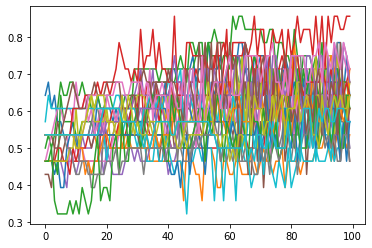

In [ ]:
dfs = {result.log_dir: result.metrics_dataframe for result in results}
[d.mean_accuracy.plot() for d in dfs.values()]